In [10]:
from sklearn.svm import SVR
from trainer.embed import load_embedding_data
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from PlanRegr.metrics import relative_error_mean, relative_error
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
from trainer.embed import load_embedding_data
from sklearn.metrics import mean_absolute_error, mean_squared_error
from PlanRegr.metrics import relative_error_mean, relative_error

In [6]:
sample_name = "wikidata_0_1_10_v2_path_hybrid"
config = {
    "reg_train_path" : f"/data/{sample_name}/reg_train_sampled.pickle",
"reg_val_path" : f"/data/{sample_name}/reg_val_sampled.pickle",
"reg_test_path" : f"/data/{sample_name}/reg_test_sampled.pickle",
}

In [7]:
def prepare(path):
    ids, embeds, lats = load_embedding_data(path)
    X = np.vstack(embeds)
    y = np.vstack(lats)
    y = y.reshape((-1,))
    return X, y, ids
train_X, train_y, train_ids = prepare(config['reg_train_path'])
val_X, val_y, val_ids = prepare(config['reg_val_path'])
test_X, test_y, test_ids = prepare(config['reg_test_path'])

In [8]:
def print_message(preds, gt):
    r = relative_error_mean(preds,gt)
    print(f"Relative error is {r}, mse: {mean_squared_error(preds, gt)} mae: {mean_absolute_error(preds, gt)}, r2: {r2_score(preds, gt)}")
    pred2 = preds.copy()
    pred2[pred2<0] = 0
    r = relative_error_mean(pred2,gt)
    print(f"Non-negative: Relative error is {r}, mse: {mean_squared_error(pred2, gt)} mae: {mean_absolute_error(pred2, gt)}, r2: {r2_score(preds, gt)}")

In [13]:
tree_size = [1000, 2000, 5000]
models = [xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.01, max_depth = 20, alpha = 10, n_estimators =x) for x in tree_size]
for m in models:
    m.fit(train_X,train_y)
    train_preds = m.predict(train_X)
    print_message(train_preds, train_y)

Relative error is 1969.4940185546875, mse: 2441.3515625 mae: 4.008981704711914, r2: 0.7861859304444216
Non-negative: Relative error is 1968.8734130859375, mse: 2441.3515625 mae: 4.007643699645996, r2: 0.7861859304444216
Relative error is 1964.1719970703125, mse: 2441.0849609375 mae: 3.967292308807373, r2: 0.7871737649578443
Non-negative: Relative error is 1963.5810546875, mse: 2441.0849609375 mae: 3.965994119644165, r2: 0.7871737649578443
Relative error is 1963.4949951171875, mse: 2441.076171875 mae: 3.9639413356781006, r2: 0.7872156760882549
Non-negative: Relative error is 1962.957275390625, mse: 2441.076171875 mae: 3.9627363681793213, r2: 0.7872156760882549


In [15]:
#last model is best
xgb_reg = models[-1]
train_preds = xgb_reg.predict(train_X)
list(train_preds)

[0.32616287,
 0.007334629,
 0.027299644,
 0.32616287,
 0.32616287,
 0.0071048047,
 0.004045828,
 0.32616287,
 0.0065019834,
 1.4414392,
 0.028560957,
 0.009135271,
 0.32616287,
 -0.01980058,
 4.7905746,
 2.122536,
 0.007962504,
 0.05344982,
 0.726177,
 0.0046791704,
 -0.0023994602,
 0.004239338,
 0.0065019834,
 0.009080324,
 0.32616287,
 0.014519235,
 0.0048505953,
 0.38707995,
 0.0046791704,
 0.010361978,
 899.92554,
 16.415773,
 0.0046094474,
 0.009856613,
 0.0048330007,
 0.0036370177,
 -0.0059804763,
 0.007334629,
 0.0065019834,
 0.004237701,
 0.0097345915,
 -0.0052968427,
 0.0048573674,
 4.304574,
 0.060996197,
 45.488613,
 0.0046514105,
 0.015266077,
 4.304574,
 7.069916,
 0.035879426,
 48.968426,
 48.968426,
 0.010225624,
 0.010225624,
 0.40211594,
 -0.0008327339,
 1.7452055,
 0.0046791704,
 2.3694754,
 0.32616287,
 0.009293251,
 0.00742692,
 0.012894445,
 0.0058670808,
 0.004237701,
 0.004045828,
 0.14183505,
 273.07507,
 0.010860805,
 1.955607,
 0.0065019834,
 0.0011888013,
 0.

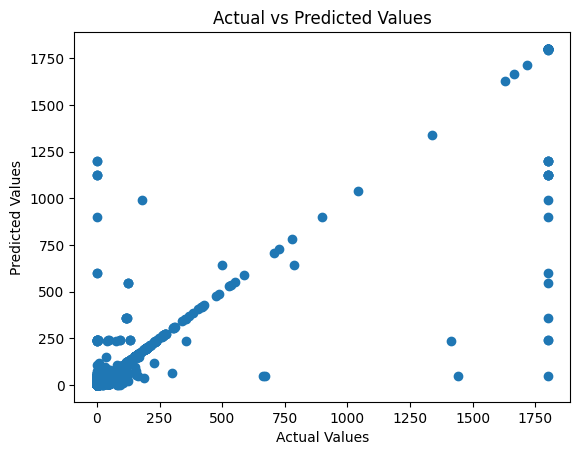

In [16]:
def good_fit_plot(preds, gt):
    plt.scatter(gt, preds)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.show()
good_fit_plot(train_preds, train_y)

## Now we try a different regression model instead

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
%%capture forest_prints
forest_models = []
for x in [1000,10000]:
    forest = RandomForestRegressor(n_estimators = x, criterion = 'squared_error', random_state=42, n_jobs=-1)
    forest.fit(train_X, train_y)
    forest_models.append(forest)
    train_preds = forest.predict(train_X)
    print_message(train_preds, train_y)